In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

### Read in top 5 stations

In [3]:
station_count = 5

In [4]:
df = pd.read_csv('../../data/station/stations.csv')

In [5]:
station_codes = df.iloc[:station_count]['code'].to_numpy()

In [6]:
station_codes

array(['SONDOC', 'LOCTHUAN', 'ANTHUAN', 'BINHDAI', 'BENTRAI'],
      dtype=object)

### Read in top 5 station train/test dataset

In [7]:
train_start_year = 2002
train_end_year = 2010

test_year = 2011

value_field = 'max'
season_length = 365

train_station_data = {}  # dictionary by station code
test_station_data = {} # dictionary by station code

In [8]:
for code in station_codes:
    # train
    df = pd.read_csv(f'../../data/train/{code}.csv', parse_dates=['date'])
    
    df.set_index('date', inplace=True)
    df.index.freq = 'D'
    
    train_station_data[code] = df
    
    # test
    df = pd.read_csv(f'../../data/test/{code}-{test_year}.csv', parse_dates=['date'])
    
    df.set_index('date', inplace=True)
    df.index.freq = 'D'
    
    test_station_data[code] = df

### Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_check(df, code, field):
    result = adfuller(df[field], autolag='AIC')

    print(f'Augmented Dickey-Fuller Test of Station {code} on field {field}:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    if result[1] <= 0.05:
        print(f'{field} of station {code} is stationary!!!')
    else:
        print(f'{field} of station {code} is NON-STATIONARY :(')

In [11]:
for code, df in train_station_data.items():
    adf_check(df, code, value_field)
    print(80 * '-')

Augmented Dickey-Fuller Test of Station SONDOC on field max:
ADF Test Statistic: -4.048357143422186
p-value: 0.001177426575819273
#Lags Used: 27
Number of Observations Used: 3259
max of station SONDOC is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station LOCTHUAN on field max:
ADF Test Statistic: -4.90115663359483
p-value: 3.469402178091689e-05
#Lags Used: 28
Number of Observations Used: 3258
max of station LOCTHUAN is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station ANTHUAN on field max:
ADF Test Statistic: -5.3677011840878714
p-value: 3.958499451328022e-06
#Lags Used: 26
Number of Observations Used: 3260
max of station ANTHUAN is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station BINHDAI on field max:
ADF Test Statistic: -5.4887111582

### Verify ARIMA requirements

In [12]:
import random

#### Pick a random station as an example

In [13]:
station_code = [*train_station_data.keys()][random.randint(0, station_count - 1)]

station_code

'SONDOC'

In [14]:
train_data = train_station_data[station_code][value_field]

#### Seasonal Decomporision

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
plt.rcParams['figure.figsize'] = (20, 10)

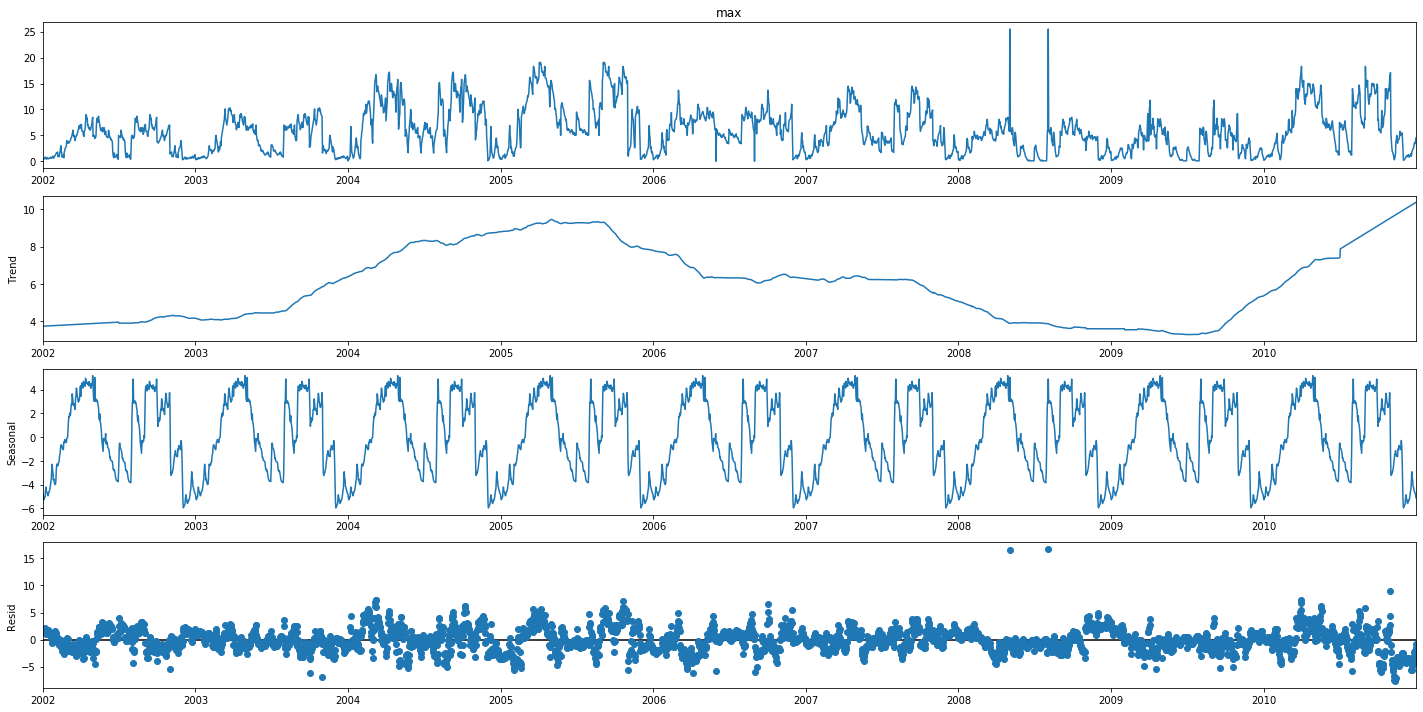

In [17]:
p = seasonal_decompose(train_data, model='additive', period=season_length, extrapolate_trend=season_length).plot();

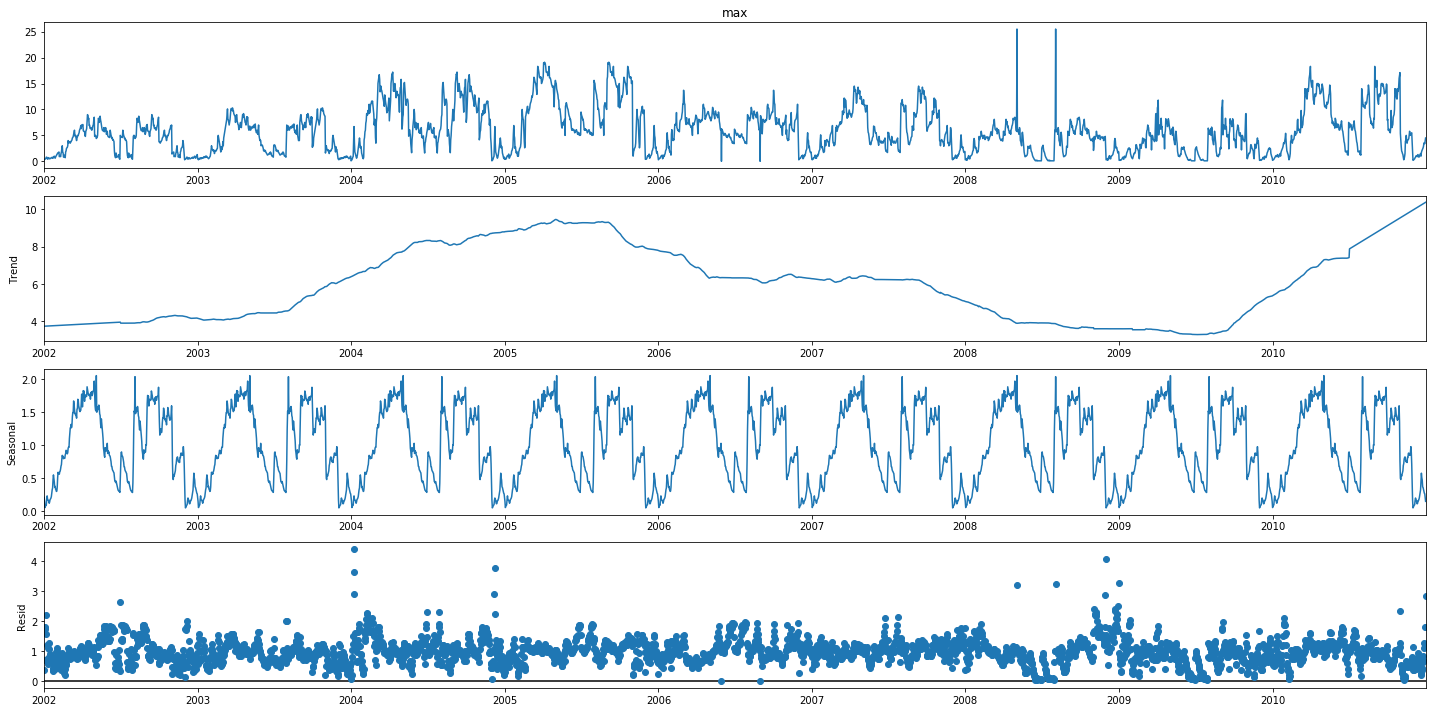

In [18]:
p = seasonal_decompose(train_data, model='multiplicative', period=season_length, extrapolate_trend=season_length).plot()

#### Visualize value changes (percentage)

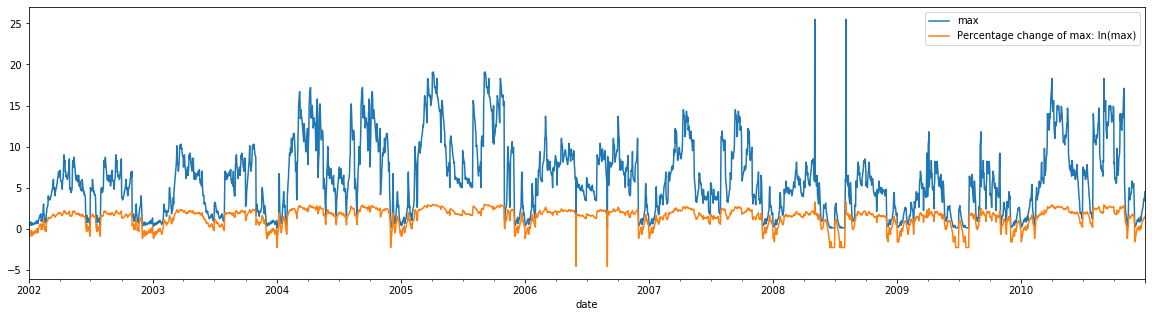

In [19]:
df = pd.DataFrame()
df[value_field] = train_data

col = f'Percentage change of {value_field}: ln({value_field})'
df[col] = np.log(train_data)

df.plot(figsize=(20, 5));

#### SMA - Simple Moving Average

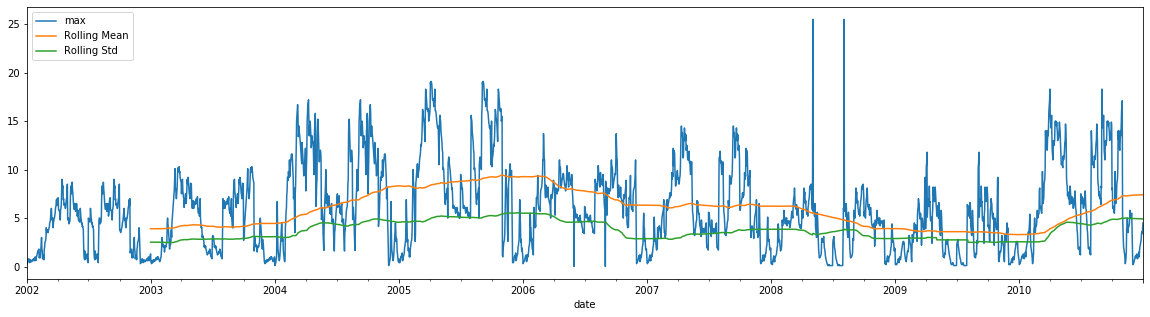

In [20]:
train_data.plot(figsize=(20, 5))
df[value_field].rolling(window=season_length).mean().plot(label='Rolling Mean')
df[value_field].rolling(window=season_length).std().plot(label='Rolling Std')
plt.legend(loc='upper left');

There is another trend on of 4 years (2005, 2006)

#### EWMA - Exponentially-weighted moving average

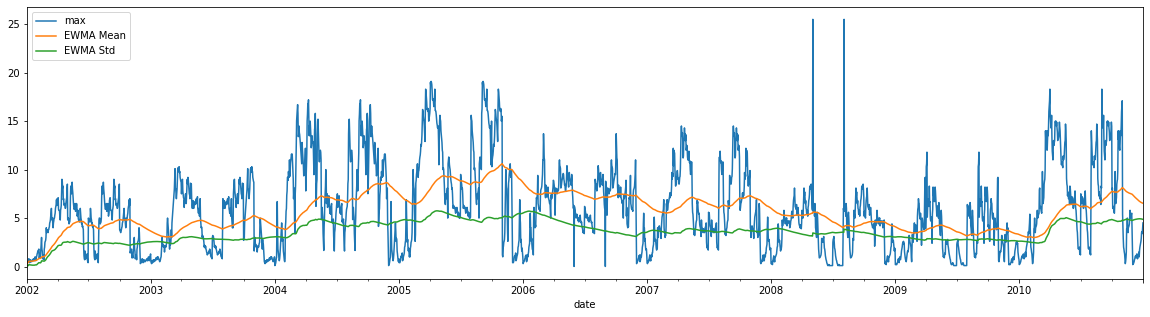

In [21]:
train_data.plot(figsize=(20, 5))
df[value_field].ewm(span=season_length).mean().plot(label='EWMA Mean')
df[value_field].ewm(span=season_length).std().plot(label='EWMA Std')
plt.legend(loc='upper left');

#### Autocovariance, Autocorrelation, and Partial Autocorrelation

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

In [23]:
plt.rcParams['figure.figsize'] = (20, 5)

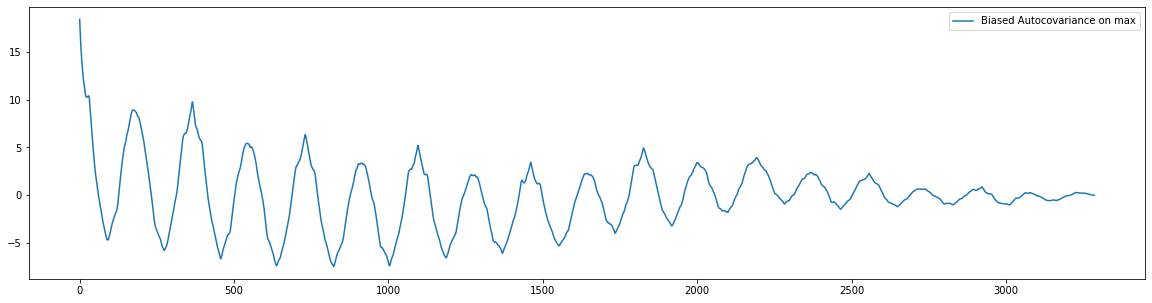

In [24]:
# Biased Autocovariance
plt.plot(acovf(train_data, fft=True), label='Biased Autocovariance on max')
plt.legend();

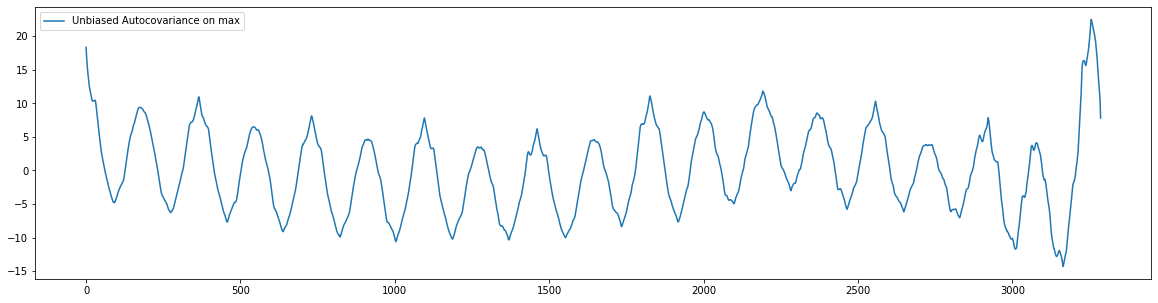

In [25]:
# Unbiased Autocovariance
plt.plot(acovf(train_data, fft=True, unbiased=True), label='Unbiased Autocovariance on max')
plt.legend();

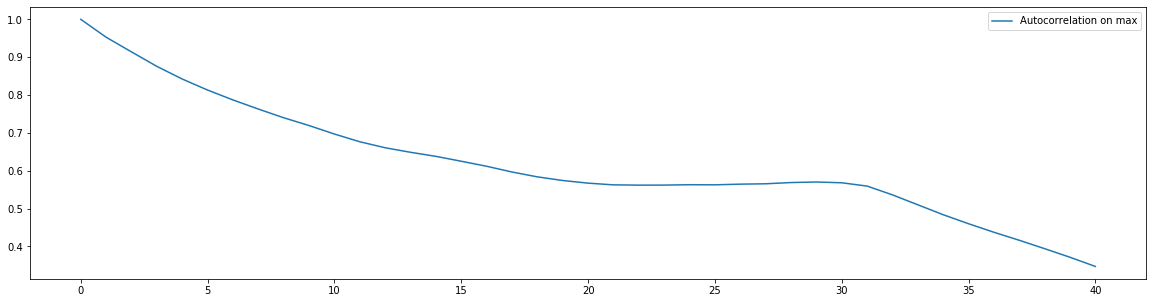

In [26]:
# Autocorrelation
plt.plot(acf(train_data, fft=True, unbiased=True), label='Autocorrelation on max')
plt.legend();

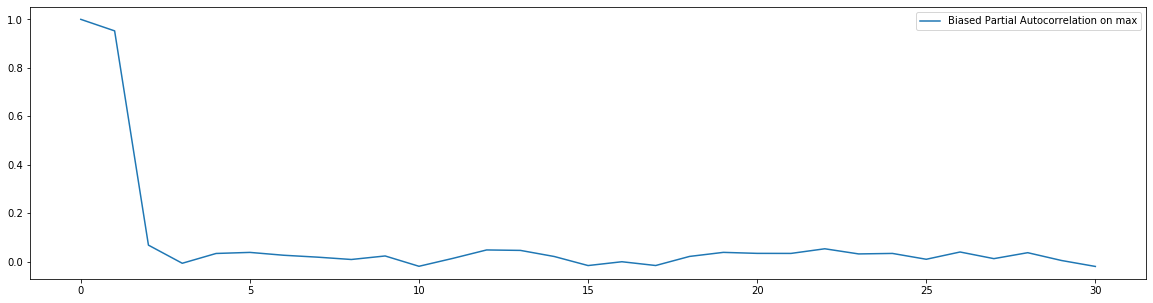

In [27]:
# Biased Partial Autocorrelation using 'mle' - maximum likelihood estimation - with Yule-Walker
plt.plot(pacf_yw(train_data, nlags=30, method='mle'), label='Biased Partial Autocorrelation on max')
plt.legend();

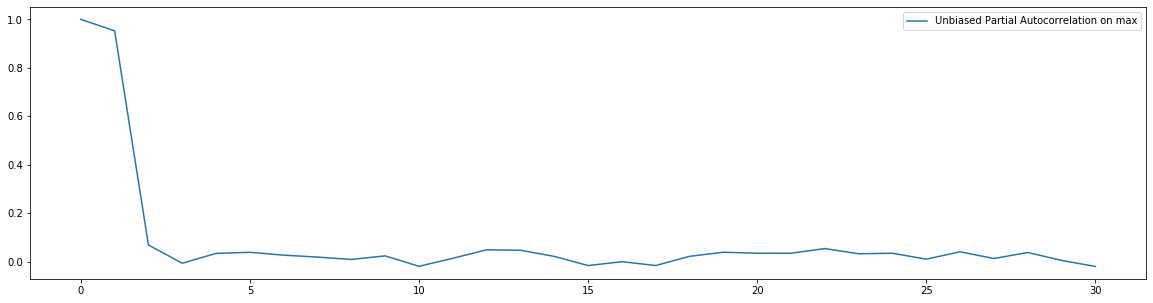

In [28]:
# Unbiased Partial Autocorrelation
plt.plot(pacf_yw(train_data, nlags=30, method='unbiased'), label='Unbiased Partial Autocorrelation on max')
plt.legend();

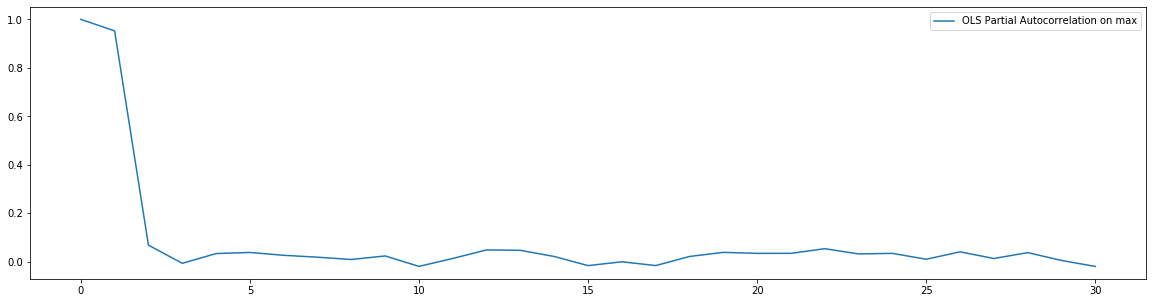

In [29]:
# Partial Autocorrelation using ordinary least squares (OLS) estimates for each lag instead of Yule-Walker.
plt.plot(pacf_ols(train_data, nlags=30), label='OLS Partial Autocorrelation on max')
plt.legend();

#### Lags, Autocorrelation, and Partial Autocorrelation
The arrays returned by <tt>.acf()</tt> and <tt>.pacf_yw()</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way:

In [30]:
from pandas.plotting import lag_plot

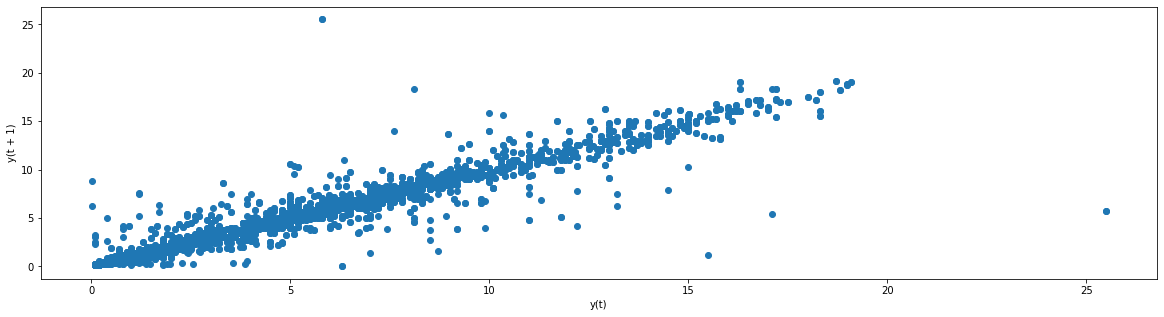

In [31]:
lag_plot(train_data);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

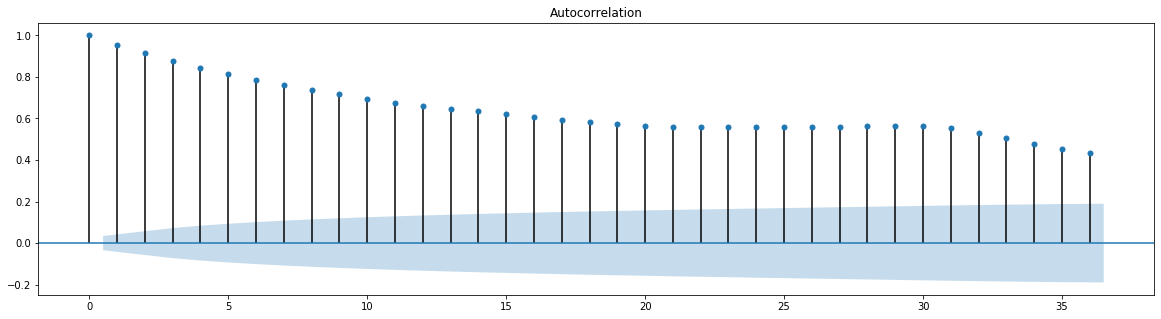

In [32]:
# Autocorrelation
plot_acf(train_data);

##### Both min and max values from 5 critical stations have gradual decline, not sharp drop, in their autocorelation plots which indicate the data is non-stationary  
1. The Autocorrelation plots show POSITIVE autocorrelation at the first lag (lag-1), then they suggest to use AR terms in the relation to the lag
2. If the Autocorrelation plots show NEGATIVE autocorrelation at the first lag, then they suggest to use MA terms in the relation to the lag

ACF is best for deciding MA models

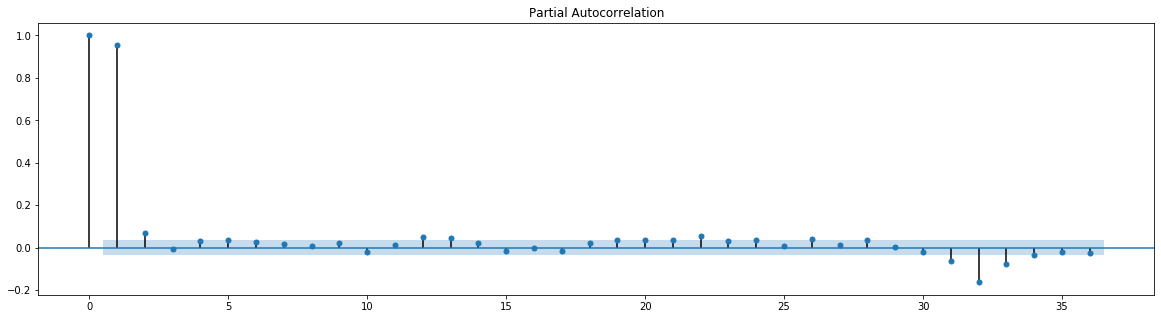

In [33]:
# Partial Autocorrelation
plot_pacf(train_data);

##### Both min and max values from 5 critical stations have sharp drop in their partial autocorelation plots  
1. Typically a sharp drop after lag k suggests an AR-k model should be used. PACF is best for deciding AR models
2. If there is an gradual decline, it suggests an MA model

In our case of these stations, k = 2 on AR models

### Pyramid ARIMA aka Auto-ARIMA

In [34]:
from statsmodels.tsa.arima_model import ARIMA

In [35]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

In [36]:
from pmdarima import auto_arima

In [37]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima``

#### Resample to monthly data points

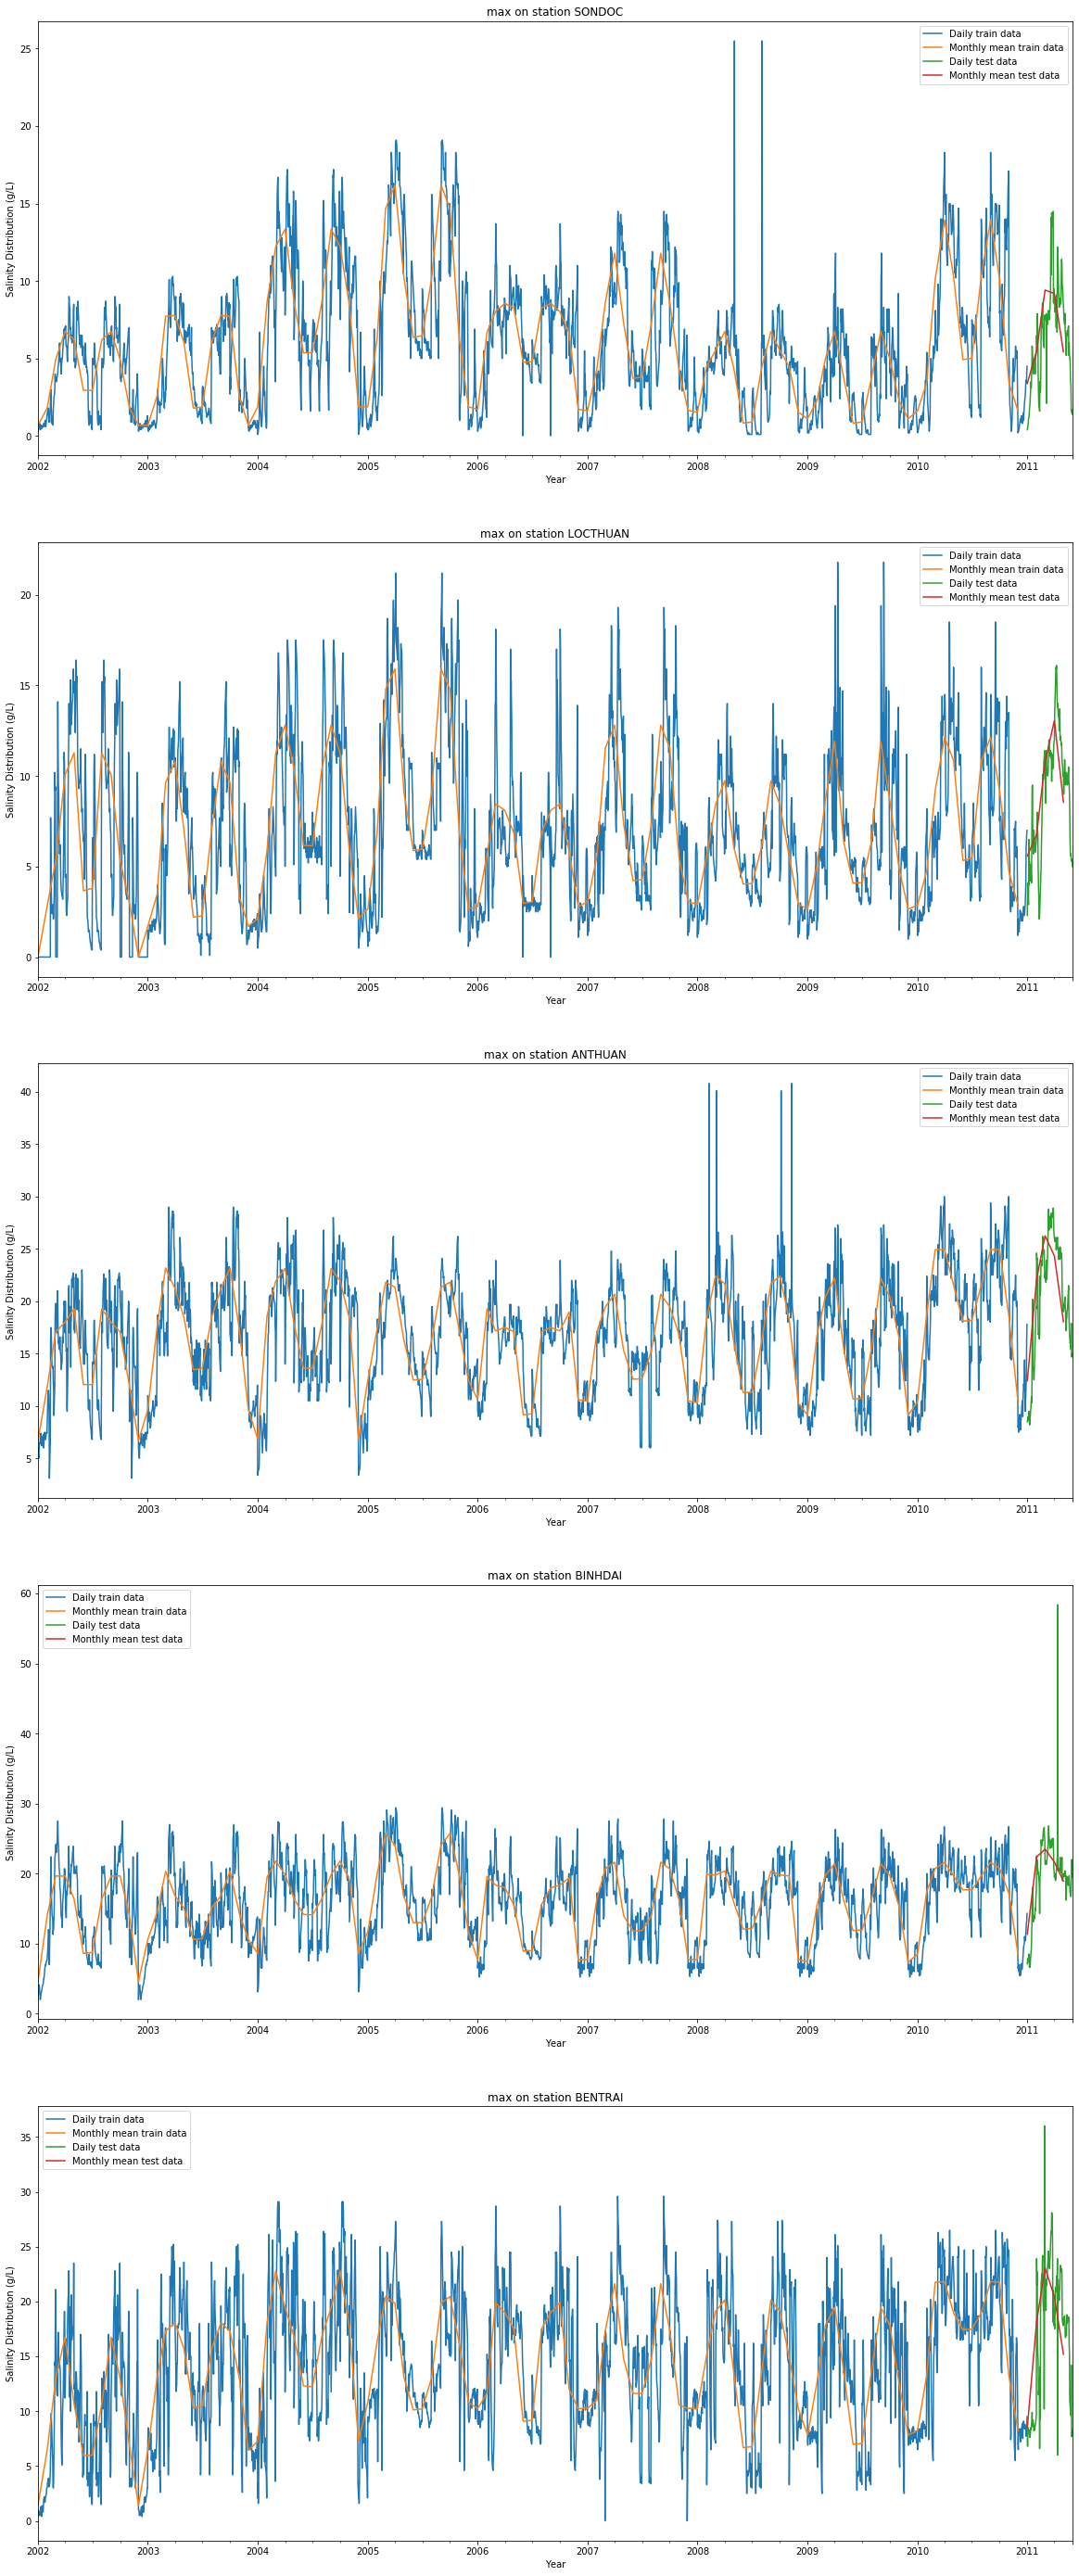

In [38]:
fig, axes = plt.subplots(nrows=station_count, ncols=1, figsize=(20, 10 * station_count))

for index, code in zip(range(0, station_count), station_codes):
    ax = axes[index]
    
    # train
    df = train_station_data[code]
    df1 = df[value_field].resample('MS').mean()
    train_station_data[code] = [df, df1]
    
    df[value_field].plot(ax=ax, label='Daily train data', legend=True)
    df1.plot(ax=ax, label='Monthly mean train data', legend=True)
    
    # test
    df = test_station_data[code]
    df1 = df[value_field].resample('MS').mean()
    test_station_data[code] = [df, df1]
    
    df[value_field].plot(ax=ax, label='Daily test data', legend=True)
    df1.plot(ax=ax, label='Monthly mean test data', legend=True)
    
    # plot annotation
    ax.set_title(f'{value_field} on station {code}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Salinity Distribution (g/L)');

#### Grid search for best SARIMAX parameters

In [39]:
# using monthly data
train_data = train_station_data[station_code][1]
test_data = test_station_data[station_code][1]

In [40]:
def grid_search_sarimax(data, trace=True):
     return auto_arima(data,
                       start_p=0, start_q=0,
                       max_p=6, max_q=6, 
                       m=12,                    # 12 month season
                       start_P=0, 
                       seasonal=True,
                       d=None, 
                       D=1, 
                       trace=trace,
                       error_action='ignore',   # we don't want to know if an order does not work
                       suppress_warnings=True,  # we don't want convergence warnings
                       stepwise=True)           # set to stepwise

In [41]:
stepwise_model = grid_search_sarimax(train_data)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 12) (constant=True); AIC=485.526, BIC=493.219, Time=0.258 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=492.538, BIC=497.667, Time=0.008 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=399.611, BIC=409.868, Time=0.108 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=414.693, BIC=424.950, Time=0.246 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=492.460, BIC=495.025, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=424.170, BIC=431.863, Time=0.023 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 12) (constant=True); AIC=399.981, BIC=412.803, Time=0.293 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 12) (constant=True); AIC=388.878, BIC=401.699, Time=0.385 seconds
Near non-invertible r

In [42]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(5, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -179.386
Date:                            Sun, 22 Mar 2020   AIC                            378.773
Time:                                    04:40:41   BIC                            404.416
Sample:                                         0   HQIC                           389.138
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0314      0.086      0.366      0.714      -0.137       0.200
ar.L1          0.0443      0.187      0.237      0.812      -0.321       0.410
ar.L2          0.4947      0.123      4.016      0.000       0.253       0.736
ar.L3         -0.2079      0.129     -1.605      0.108      -0.462       0.046
ar.L4          0.1492      0.133      1.120      0.263      -0.112       0.410
ar.L5          0.3328      0.117      2.843      0.004       0.103       0.562
ma.L1          0.9390      0.131      7.151      0.000       0.682       1.196
ar.S.L12      -0.0521      0.164     -0.317      0.751      -0.374       0.270
ma.S.L12      -0.9893      3.500     -0.283      0.777      -7.850       5.871
sigma2         1.8200      6.282      0.290      0.772     -10.492      14.132
===================================================================================
Ljung-Box (Q):                       27.01   Jarque-Bera (JB):                 6.38
Prob(Q):                              0.94   Prob(JB):                         0.04
Heteroskedasticity (H):               0.79   Skew:                             0.49
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# fit the model with train set - NO NEED TO FIT IF USING THE SAME TRAINING SET
#stepwise_model.fit(train_data)

In [44]:
# use model to predict
predictions = stepwise_model.predict(n_periods=len(test_data))

In [45]:
predictions = pd.Series(predictions, index=test_data.index)

#### Verify predictions against test set

In [46]:
predictions

date
2011-01-01    2.92111
2011-02-01    6.82819
2011-03-01    9.80146
2011-04-01   10.65226
2011-05-01    7.69488
Freq: MS, dtype: float64

In [47]:
test_data

date
2011-01-01   3.38710
2011-02-01   5.51786
2011-03-01   9.41290
2011-04-01   9.19000
2011-05-01   5.42903
Freq: MS, Name: max, dtype: float64

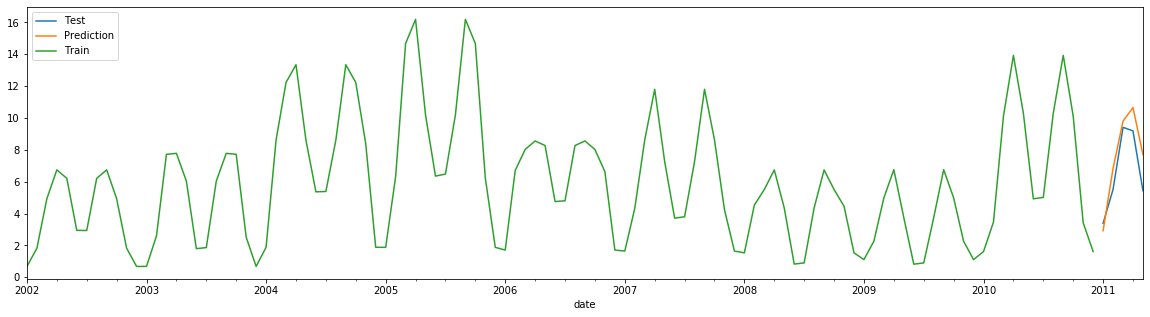

In [48]:
test_data.plot(legend=True, label='Test')
predictions.plot(legend=True, label='Prediction')
train_data.plot(legend=True, figsize=(20,5), label='Train');

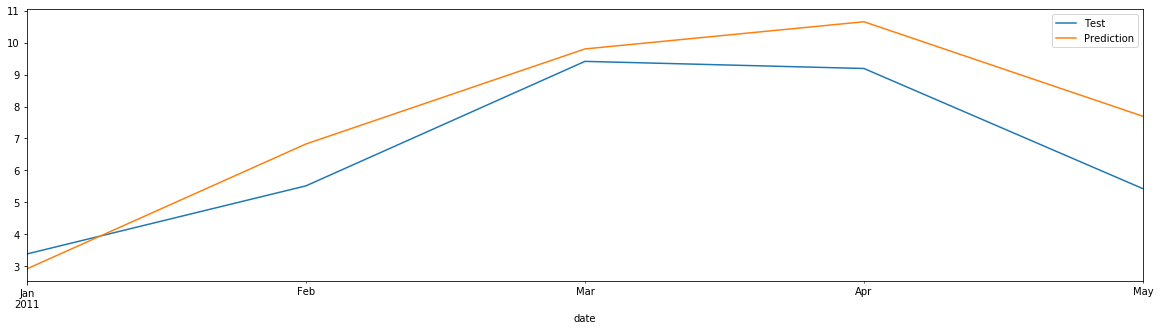

In [49]:
test_data.plot(legend=True, figsize=(20,5), label='Test')
predictions.plot(legend=True, label='Prediction');

#### Evaluating models

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [51]:
rmse_vs_std_limit = 60  # 60%

In [52]:
test_data.describe()

count   5.00000
mean    6.58738
std     2.62129
min     3.38710
25%     5.42903
50%     5.51786
75%     9.19000
max     9.41290
Name: max, dtype: float64

In [53]:
predictions.describe()

count    5.00000
mean     7.57958
std      3.02727
min      2.92111
25%      6.82819
50%      7.69488
75%      9.80146
max     10.65226
dtype: float64

In [54]:
test_std = test_data.std()

test_std

2.621291366985242

In [55]:
mae = mean_absolute_error(test_data, predictions)

mae

1.1785980142500232

In [56]:
mse = mean_squared_error(test_data, predictions)

mse

1.8714760761188476

In [57]:
rmse = np.sqrt(mse)

rmse

1.3680190335367588

In [58]:
print(f'Prediction RMSE {round(rmse, 2)} vs. Test STD {round(test_std, 2)}')

Prediction RMSE 1.37 vs. Test STD 2.62


In [59]:
import math

In [60]:
error_percent = math.ceil(100.0 * rmse / test_std)
print(f'Error in form of RMSE is about {error_percent}% of Test STD => {"GOOD ENOUGH" if error_percent <= rmse_vs_std_limit else "BAD"}')

Error in form of RMSE is about 53% of Test STD => GOOD ENOUGH


#### Append test set into train set and use it for production

From Jan 1, 2002 to May 31, 2011

In [61]:
final_data = pd.concat([train_data, test_data])

In [62]:
# refit the mode with final data set
stepwise_model.fit(final_data)

ARIMA(maxiter=50, method='lbfgs', order=(5, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

#### Predict for the rest of the test year

In [63]:
predictions = stepwise_model.predict(n_periods=7)  # from Jun to Dec

In [64]:
predictions = pd.Series(predictions, index=pd.date_range(start=f'{test_year}-06-01', end=f'{test_year}-12-31', freq='MS'))

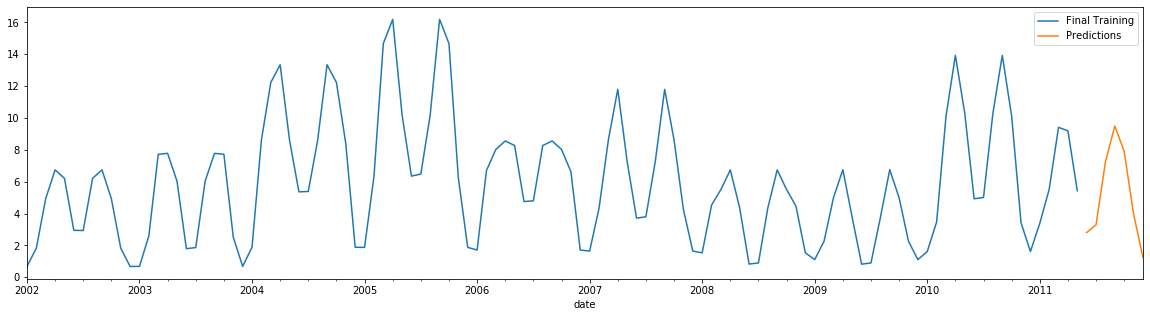

In [65]:
final_data.plot(legend=True, figsize=(20,5), label='Final Training')
predictions.plot(legend=True, label='Predictions');

#### Save model

In [66]:
import pickle

In [67]:
def save_model(model, code):
    with open(f'../../data/model/{code}.pkl', 'wb') as pkl:
        pickle.dump(model, pkl)

In [68]:
save_model(stepwise_model, station_code)

### Expand evaluation to other years where data are available

In [69]:
def load_model(code):
    with open(f'../../data/model/{code}.pkl', 'rb') as pkl:
        return pickle.load(pkl)

In [70]:
stepwise_model = load_model(station_code)

In [71]:
eval_data = pd.DataFrame()

eval_start_year = 2012
eval_end_year = 2025

In [72]:
for year in range(eval_start_year, eval_end_year + 1):
    try:
        df = pd.read_csv(f'../../data/evaluation/{station_code}-{year}.csv', parse_dates=['date'])
        df.set_index('date', inplace=True)
        
        # using max resample since this is further from the side of test set
        df = df[value_field].resample('MS').max()

        # using mean resample as train/test/final datasets
        #df = df[value_field].resample('MS').mean()

        if eval_data.empty:
            eval_data = df
        else:
            eval_data = pd.concat([eval_data, df])
    except:
        continue

In [73]:
eval_data.head()

date
2012-02-01    4.00000
2012-03-01    7.40000
2012-04-01   13.10000
2012-05-01    7.22500
2012-06-01    2.87500
Name: max, dtype: float64

In [74]:
eval_data.tail()

date
2018-01-01    0.20000
2018-02-01    6.60000
2018-03-01   10.90000
2018-04-01   12.10000
2018-05-01    8.50000
Name: max, dtype: float64

In [75]:
months = 7  # For Jun 2011 till Dec 2011
months += (eval_end_year - eval_start_year + 1) * 12  # number of months in those evaluation years

In [76]:
forecast = stepwise_model.predict(n_periods=months)

In [77]:
forecast = pd.Series(forecast, index=pd.date_range(start=f'{eval_start_year - 1}-06-01', end=f'{eval_end_year}-12-31', freq='MS'))

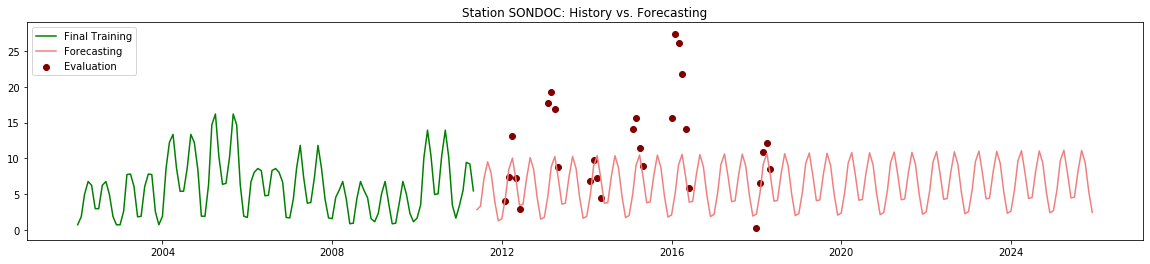

In [78]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(final_data.index, final_data, c='green', label='Final Training')
ax.plot(forecast.index, forecast, c='lightcoral', label='Forecasting')
ax.scatter(x=eval_data.index, y=eval_data, c='maroon', label='Evaluation')

plt.title(f'Station {station_code}: History vs. Forecasting')
ax.legend(loc='upper left');

#### Metrics on evaluation vs. forecasting

In [79]:
eval_data.describe()

count   28.00000
mean    11.61339
std      6.71374
min      0.20000
25%      7.11875
50%     10.30000
75%     15.70000
max     27.40000
Name: max, dtype: float64

In [80]:
eval_std = eval_data.std()

#### Extract part of forecast match with evaluation samples

In [81]:
eval_forecast_data = forecast[eval_data.index]

In [82]:
eval_forecast_data.head()

date
2012-02-01    4.50413
2012-03-01    8.46791
2012-04-01   10.01946
2012-05-01    7.06481
2012-06-01    3.43373
dtype: float64

In [83]:
eval_forecast_data.tail()

date
2018-01-01    2.19320
2018-02-01    5.20080
2018-03-01    9.19673
2018-04-01   10.66696
2018-05-01    7.59232
dtype: float64

In [84]:
mse = mean_squared_error(eval_data, eval_forecast_data)

mse

59.09268815739586

In [85]:
rmse = np.sqrt(mse)

rmse

7.687176865234457

In [86]:
print(f'Prediction RMSE {round(rmse, 2)} vs. Test STD {round(eval_std, 2)}')

Prediction RMSE 7.69 vs. Test STD 6.71


In [87]:
error_percent = math.ceil(100.0 * rmse / eval_std)
print(f'Error in form of RMSE is about {error_percent}% of Evaluation STD => {"GOOD ENOUGH" if error_percent <= rmse_vs_std_limit else "BAD"}')

Error in form of RMSE is about 115% of Evaluation STD => BAD


### Construct final models for all top stations

In [88]:
for code, df in train_station_data.items():
    print(f'>>>>> Station {code} Grid Search Summary {49 * ">"}')
    
    # using monthly data
    final_data = pd.concat([train_station_data[code][1], 
                            test_station_data[station_code][1]])
    
    model = grid_search_sarimax(final_data, trace=False)
    print(model.summary())
    
    save_model(model, code)
    
    print(80 * '>')

>>>>> Station SONDOC Grid Search Summary >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  113
Model:             SARIMAX(5, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -187.533
Date:                            Sun, 22 Mar 2020   AIC                            395.065
Time:                                    04:41:30   BIC                            421.217
Sample:                                         0   HQIC                           405.652
                                            - 113                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132  

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  113
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -233.705
Date:                              Sun, 22 Mar 2020   AIC                            477.409
Time:                                      04:41:49   BIC                            490.485
Sample:                                           0   HQIC                           482.702
                                              - 113                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0106      0.066      0.161      0.872      -0.118       0.139
ar.L1          0.80